In [36]:
# CARGAMOS LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

import boto3
import s3fs
import fastparquet
import awswrangler as wr
import os

import pyarrow.parquet as pq
import pyarrow as pa

import requests
import json
from io import BytesIO
from pandas.tseries.offsets import BDay

import math

In [37]:
# INICIALIZAMOS UNA SESION EN AWS
session = boto3.Session(
    aws_access_key_id=os.environ['S3_ACCESS_KEY'],
    aws_secret_access_key=os.environ['S3_SECRET_KEY'],
    region_name=os.environ['S3_REGION'])

s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

In [38]:
bucket_name = 'stock-market-historical-data'
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name

In [39]:
def download_s3_parquet_file(s3, bucket, key):
    buffer = BytesIO()
    s3.Object(bucket, key).download_fileobj(buffer)
    return buffer

In [40]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
processed_folder = 'processed/marketstack/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name
marketstack_historical_data = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,full_path)).to_pandas())
marketstack_historical_data.index = pd.to_datetime(marketstack_historical_data.index)

In [41]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
processed_folder = 'processed/yfinance/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name
yfinance_historical_data = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,full_path)).to_pandas())
yfinance_historical_data.index = pd.to_datetime(yfinance_historical_data.index)

In [42]:
# CARGAMOS EL DATAFRAME CON TODOS LOS DATOS DE CIERRE DE TODOS LOS ACTIVOS DESDE 02/01/1991
processed_folder = 'processed/bme-data/'
file_name = 'ibex_historical_data'
full_path = processed_folder + file_name
bme_historical_data = pd.DataFrame(pq.read_table(download_s3_parquet_file(s3, bucket_name,full_path)).to_pandas())
bme_historical_data.drop(['NHH_1'], axis=1, inplace=True)
bme_historical_data.index = pd.to_datetime(bme_historical_data.index)


In [43]:
marketstack_historical_data.shape, yfinance_historical_data.shape, bme_historical_data.shape

((7601, 170), (6099, 170), (5159, 88))

In [44]:
marketstack_historical_data.isnull().sum().sum(), yfinance_historical_data.isnull().sum().sum(), bme_historical_data.isnull().sum().sum()

(1117104, 881853, 277577)

In [45]:
sub = 'PUL'

for ticker in bme_historical_data.columns:
    if sub in ticker:
        print(ticker)

In [46]:
marketstack_historical_data['PUL'].dropna()

date
1997-10-01    6.1620
1997-10-02    6.1620
1997-10-03    6.2312
1997-10-06    6.1969
1997-10-07    6.1392
               ...  
1999-12-27    5.5575
1999-12-28    5.5334
1999-12-29    5.5533
1999-12-30    5.7232
2000-01-03    5.6288
Name: PUL, Length: 543, dtype: float64

In [47]:
bme_historical_data['CRI'].dropna()

2008-02-04    3.4900
2008-02-05    3.2600
2008-02-06    3.3200
2008-02-07    3.2600
2008-02-08    3.3100
               ...  
2011-06-24    4.6095
2011-06-27    4.6006
2011-06-28    4.6510
2011-06-29    4.7549
2011-06-30    4.8130
Name: CRI, Length: 868, dtype: float64

In [48]:
bme_historical_data.columns

Index(['SAN', 'BTO_1', 'BKIA_0', 'BKIA', 'NTGY', 'TRE', 'ACX_0', 'ACX', 'FER',
       'ACS', 'ELE_0', 'ELE', 'SAB', 'CRI', 'OHL', 'IBR', 'EBRO_0', 'EBRO_1',
       'AMS', 'AENA', 'ITX', 'MTS', 'IAG', 'VIS_0', 'VIS', 'IBLA', 'BBVA',
       'MAP', 'BME', 'CIE', 'MAS', 'IBE', 'ABG', 'ENG', 'SCYR_1', 'REP', 'ABE',
       'ABG.P_0', 'ABG.P_1', 'ANA_0', 'ANA', 'EVA', 'GRF', 'CLNX', 'MRL',
       'BKT', 'POP', 'ENC', 'IDR', 'SGRE_0', 'SGRE', 'MEL', 'TL5', 'REE',
       'COL', 'JAZ', 'TEF', 'FCC', 'CABK', 'DIA', 'ALM', 'REE_0', 'CIN', 'LOR',
       'UNF', 'ZEL', 'NHH_0', 'MAP_0', 'ALT', 'BTO_0', 'FAD', 'DRC', 'PRS_0',
       'PRS_1', 'SCYR_0', 'TEM', 'CAR', 'AGS', 'COL_0', 'A3TV', 'SGC', 'ANE',
       'FDR', 'PHM', 'ROVI', 'SCYR', 'SLR', 'UNI'],
      dtype='object')

In [49]:
bme_historical_data = bme_historical_data.rename(columns={
    'ACX':'ACX_2',
    'ACX_0': 'ACX_1',
    'BKIA': 'BKIA_1',
    'BKIA_0': 'BKIA',
    'ABG.P_0':'ABG.P',
    'VIS':'VIS_3',
    'VIS_0':'VIS_2',
    'EBRO_0': 'EBRO',
    'BTO_1':'BTO_2',
    'BTO_0':'BTO_1',
    'SGRE_0': 'SGRE',
    'ANA': 'ANA_2',
    'ANA_0': 'ANA_1',
    'REE_0': 'REE',
    'COL_0': 'COL',
    'COL': 'COL_1',
    'MAP':'MAP_2',
    'MAP_0':'MAP_1',
    'PRS_0':'PRS',
    'ELE':'ELE_1',
    'ELE_0':'ELE',
    'ENC':'ENC_1',
    'AMS':'AMS_1',
    'SCYR':'SCYR_2',
    'SCYR_0':'SCYR',
    'OHL':'OHLA',
    'SAN':'SAN_1',
    'CRI':'CRI_2',
    })

In [50]:
ibex_historical_data = pd.DataFrame(columns=marketstack_historical_data.columns)
for c in ibex_historical_data.columns:
    try:
        ibex_historical_data[c] = marketstack_historical_data[c].fillna(yfinance_historical_data[c])
        # ibex_historical_data[c] = marketstack_historical_data[c].fillna(bme_historical_data[c])
        ibex_historical_data[c] = ibex_historical_data[c].fillna(bme_historical_data[c])
        print('ok ' + c)
    except:
        print('failed ' + c)

ok A3TV
ok ABE
ok ABG.P
ok ABG.P_1
ok ABG
failed ACE
failed ACR
ok ACS
failed ACX
ok ACX_1
ok ACX_2
ok AENA
failed AGR
ok AGS
failed AGS_1
failed AGS_2
failed AGS_3
failed ALB
failed ALB_1
failed ALB_2
failed ALB_3
ok ALM
ok ALT
failed AMP
failed AMS
ok AMS_1
failed ANA
ok ANA_1
ok ANA_2
ok ANE
failed ARA
failed ARG
failed ASL
failed AUM
failed AZC
failed AZC_1
failed BBV
ok BBVA
failed BCH
ok BKIA
ok BKIA_1
ok BKT
ok BME
failed BTO
ok BTO_1
ok BTO_2
ok CABK
failed CAN
ok CAR
failed CEN
failed CEP
failed CEP_1
ok CIE
ok CIN
ok CLNX
ok COL
ok COL_1
failed CRF
failed CRI
failed CRI_1
ok CRI_2
failed CTE
failed CTF
failed CTG
failed CUB
ok DIA
ok DRC
failed EBA
ok EBRO
ok EBRO_1
failed ECR
ok ELE
ok ELE_1
failed ENC
ok ENC_1
ok ENG
ok EVA
failed EXT
ok FAD
ok FCC
ok FDR
failed FEC
ok FER
failed FOC
failed GAM
failed GAM_1
failed GAS
failed GES
failed GES_1
failed GPP
ok GRF
failed HHU
failed HHU_1
failed HID
failed HIS
ok IAG
ok IBE
ok IBLA
ok IBR
ok IDR
ok ITX
ok JAZ
failed LOG
ok LOR
fa

In [51]:
ibex_historical_data['BTO_1'] = yfinance_historical_data['BTO_1']
ibex_historical_data['BTO_2'] = yfinance_historical_data['BTO_2']
ibex_historical_data['ABE'] = yfinance_historical_data['ABE']
ibex_historical_data['REP'] = marketstack_historical_data['REP']
ibex_historical_data['FER'] = marketstack_historical_data['FER']

In [52]:
ibex_historical_data['ABE'].fillna(ibex_historical_data['ACE'],inplace=True)
ibex_historical_data.drop(['ACE'],axis=1,inplace=True)

In [53]:
ibex_historical_data['COL'].fillna(ibex_historical_data['CAR'],inplace=True)
ibex_historical_data.drop(['CAR'],axis=1,inplace=True)

In [54]:
ibex_historical_data['BBVA'].fillna(ibex_historical_data['BBV'],inplace=True)
ibex_historical_data.drop(['BBV'],axis=1,inplace=True)

In [55]:
ibex_historical_data['benchmark'] = yf.download('^IBEX')['Adj Close']
ibex_historical_data.index = pd.to_datetime(ibex_historical_data.index)

[*********************100%***********************]  1 of 1 completed


C:\Users\aleja\AppData\Local\Temp\ipykernel_20704\3243579471.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ibex_historical_data['benchmark'] = yf.download('^IBEX')['Adj Close']


In [90]:
ibex_historical_data_cleaned.to_csv('ibex_historical_data.csv',index=True)

In [58]:
ibex_historical_data.drop(['SYV','SYV_1','GAS','ARG'],axis=1,inplace=True)

KeyError: "['SYV', 'SYV_1', 'GAS', 'ARG'] not found in axis"

In [60]:
failed_loads = ibex_historical_data.columns[ibex_historical_data.isnull().values.all(axis=0)]
print('Missing tickers are {}'.format(len(failed_loads)))
print(np.array(failed_loads))

Missing tickers are 55
['ACR' 'ACX' 'AGR' 'AGS_1' 'AGS_2' 'AGS_3' 'ALB' 'ALB_1' 'AMS' 'ARA' 'ASL'
 'AUM' 'AZC' 'AZC_1' 'BCH' 'BTO' 'CAN' 'CEN' 'CEP' 'CEP_1' 'CRF' 'CRI'
 'CRI_1' 'CTE' 'CTF' 'CTG' 'CUB' 'ECR' 'EXT' 'FEC' 'FOC' 'GES' 'GES_1'
 'GPP' 'HHU' 'HHU_1' 'HID' 'HIS' 'MVC' 'MVC_1' 'PMD' 'PRY' 'SAR' 'SCH'
 'SEV' 'TAB' 'TPI' 'TPZ' 'TRR' 'TRR_1' 'URA' 'URB' 'VAL' 'VAL_1' 'VDR']


In [61]:
for c in ibex_historical_data.columns:
    if ibex_historical_data[c].isnull().sum() != ibex_historical_data[c].shape[0]:
        first_valid = ibex_historical_data.loc[ibex_historical_data[c].notnull()][c].index[0]
        last_valid = ibex_historical_data.loc[ibex_historical_data[c].notnull()][c].index[-1]

        data = ibex_historical_data[c].loc[first_valid:last_valid]
        
        ibex_historical_data[c] = data.fillna(method='ffill')
        print(c, ibex_historical_data[c].loc[first_valid:last_valid].isnull().sum())
    else:
        print(c, 'null')
    

A3TV 0
ABE 0
ABG.P 0
ABG.P_1 0
ABG 0
ACR null
ACS 0
ACX null
ACX_1 0
ACX_2 0
AENA 0
AGR null
AGS 0
AGS_1 null
AGS_2 null
AGS_3 null
ALB null
ALB_1 null
ALB_2 0
ALB_3 0
ALM 0
ALT 0
AMP 0
AMS null
AMS_1 0
ANA 0
ANA_1 0
ANA_2 0
ANE 0
ARA null
ASL null
AUM null
AZC null
AZC_1 null
BBVA 0
BCH null
BKIA 0
BKIA_1 0
BKT 0
BME 0
BTO null
BTO_1 0
BTO_2 0
CABK 0
CAN null
CEN null
CEP null
CEP_1 null
CIE 0
CIN 0
CLNX 0
COL 0
COL_1 0
CRF null
CRI null
CRI_1 null
CRI_2 0
CTE null
CTF null
CTG null
CUB null
DIA 0
DRC 0
EBA 0
EBRO 0
EBRO_1 0
ECR null
ELE 0
ELE_1 0
ENC 0
ENC_1 0
ENG 0
EVA 0
EXT null
FAD 0
FCC 0
FDR 0
FEC null
FER 0
FOC null
GAM 0
GAM_1 0
GES null
GES_1 null
GPP null
GRF 0
HHU null
HHU_1 null
HID null
HIS null
IAG 0
IBE 0
IBLA 0
IBR 0
IDR 0
ITX 0
JAZ 0
LOG 0
LOR 0
MAP 0
MAP_1 0
MAP_2 0
MAS 0
MEL 0
MRL 0
MTS 0
MVC null
MVC_1 null
NHH 0
NHH_1 0
NHH_2 0
NTGY 0
OHLA 0
PHM 0
PMD null
POP 0
PRS 0
PRS_1 0
PRY null
PUL 0
RAD 0
RED 0
REE 0
REE_1 0
REP 0
ROVI 0
SAB 0
SAN 0
SAN_1 0
SAR null
SCH nu

In [62]:
ibex_historical_data_cleaned = ibex_historical_data.dropna(how='all',axis=1)

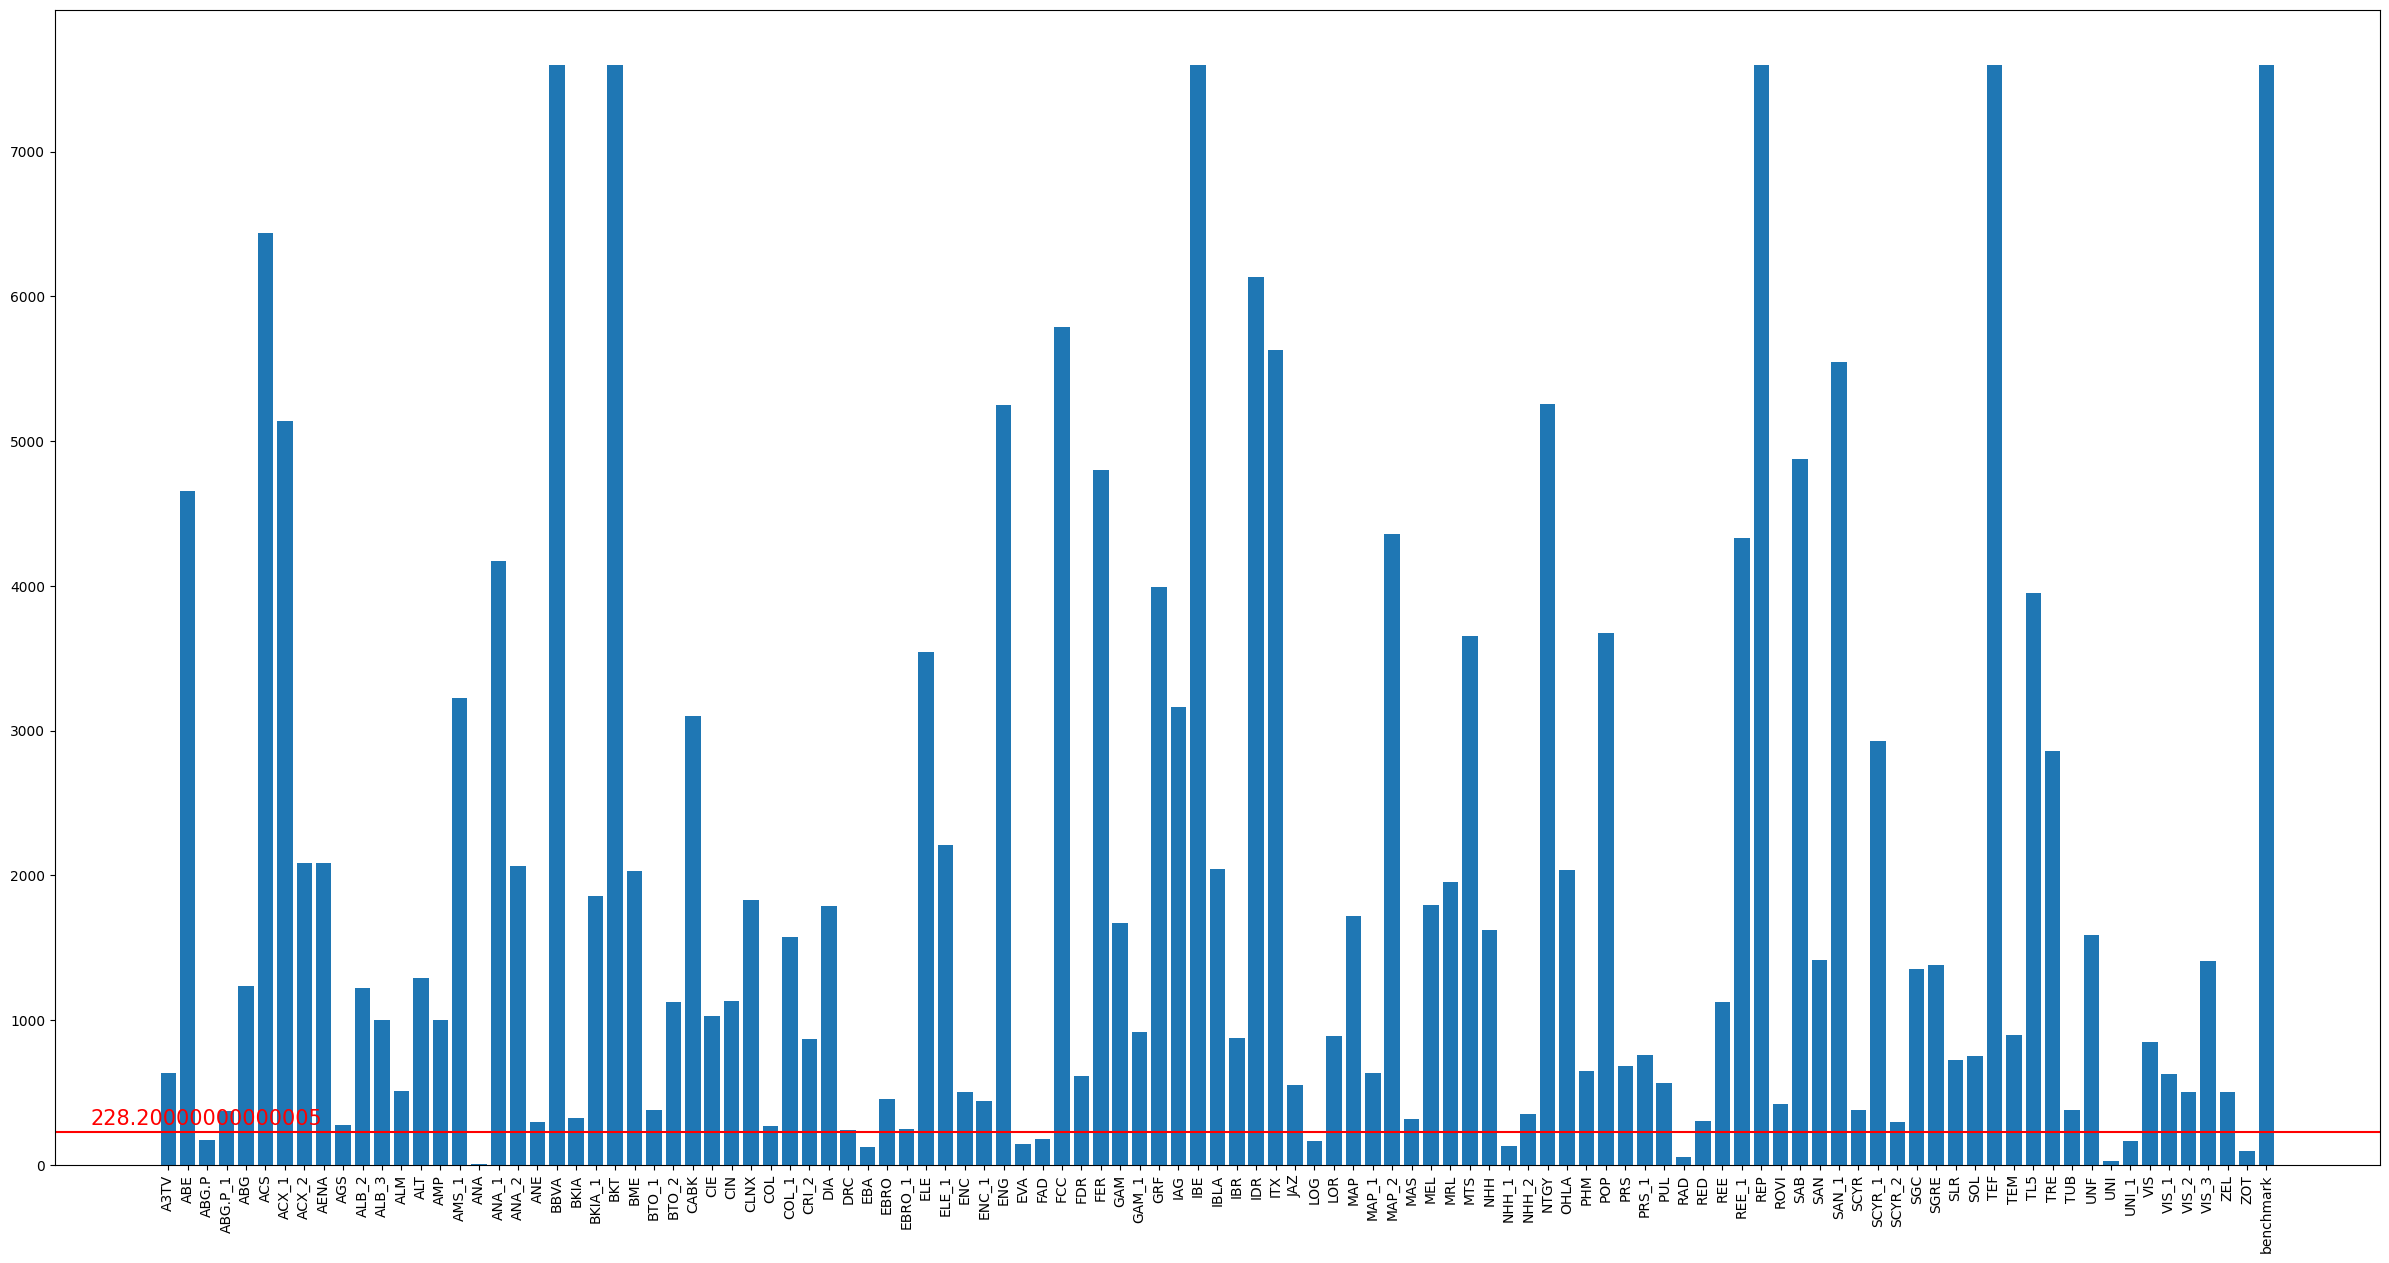

In [63]:
q = 0.1
plt.subplots(figsize=(30,15))
plt.bar(ibex_historical_data_cleaned.columns,ibex_historical_data_cleaned.notnull().sum())
plt.axhline(xmin=0,xmax=len(ibex_historical_data_cleaned.columns),y=ibex_historical_data_cleaned.notnull().sum().quantile(q),c='red')
plt.annotate(ibex_historical_data_cleaned.notnull().sum().quantile(q),xy=(-4,ibex_historical_data_cleaned.notnull().sum().quantile(q)+50),fontsize=15,c='red')
plt.xticks(rotation = 90);

In [64]:
few_registers = ibex_historical_data_cleaned.loc[:,ibex_historical_data_cleaned.notnull().sum() < ibex_historical_data_cleaned.notnull().sum().quantile(q)].columns
ibex_historical_data_cleaned = ibex_historical_data_cleaned.drop(few_registers,axis=1)

In [89]:
returns = np.log(ibex_historical_data_cleaned).diff()[1:]
returns.to_csv('ibex_historical_returns.csv',index=True)

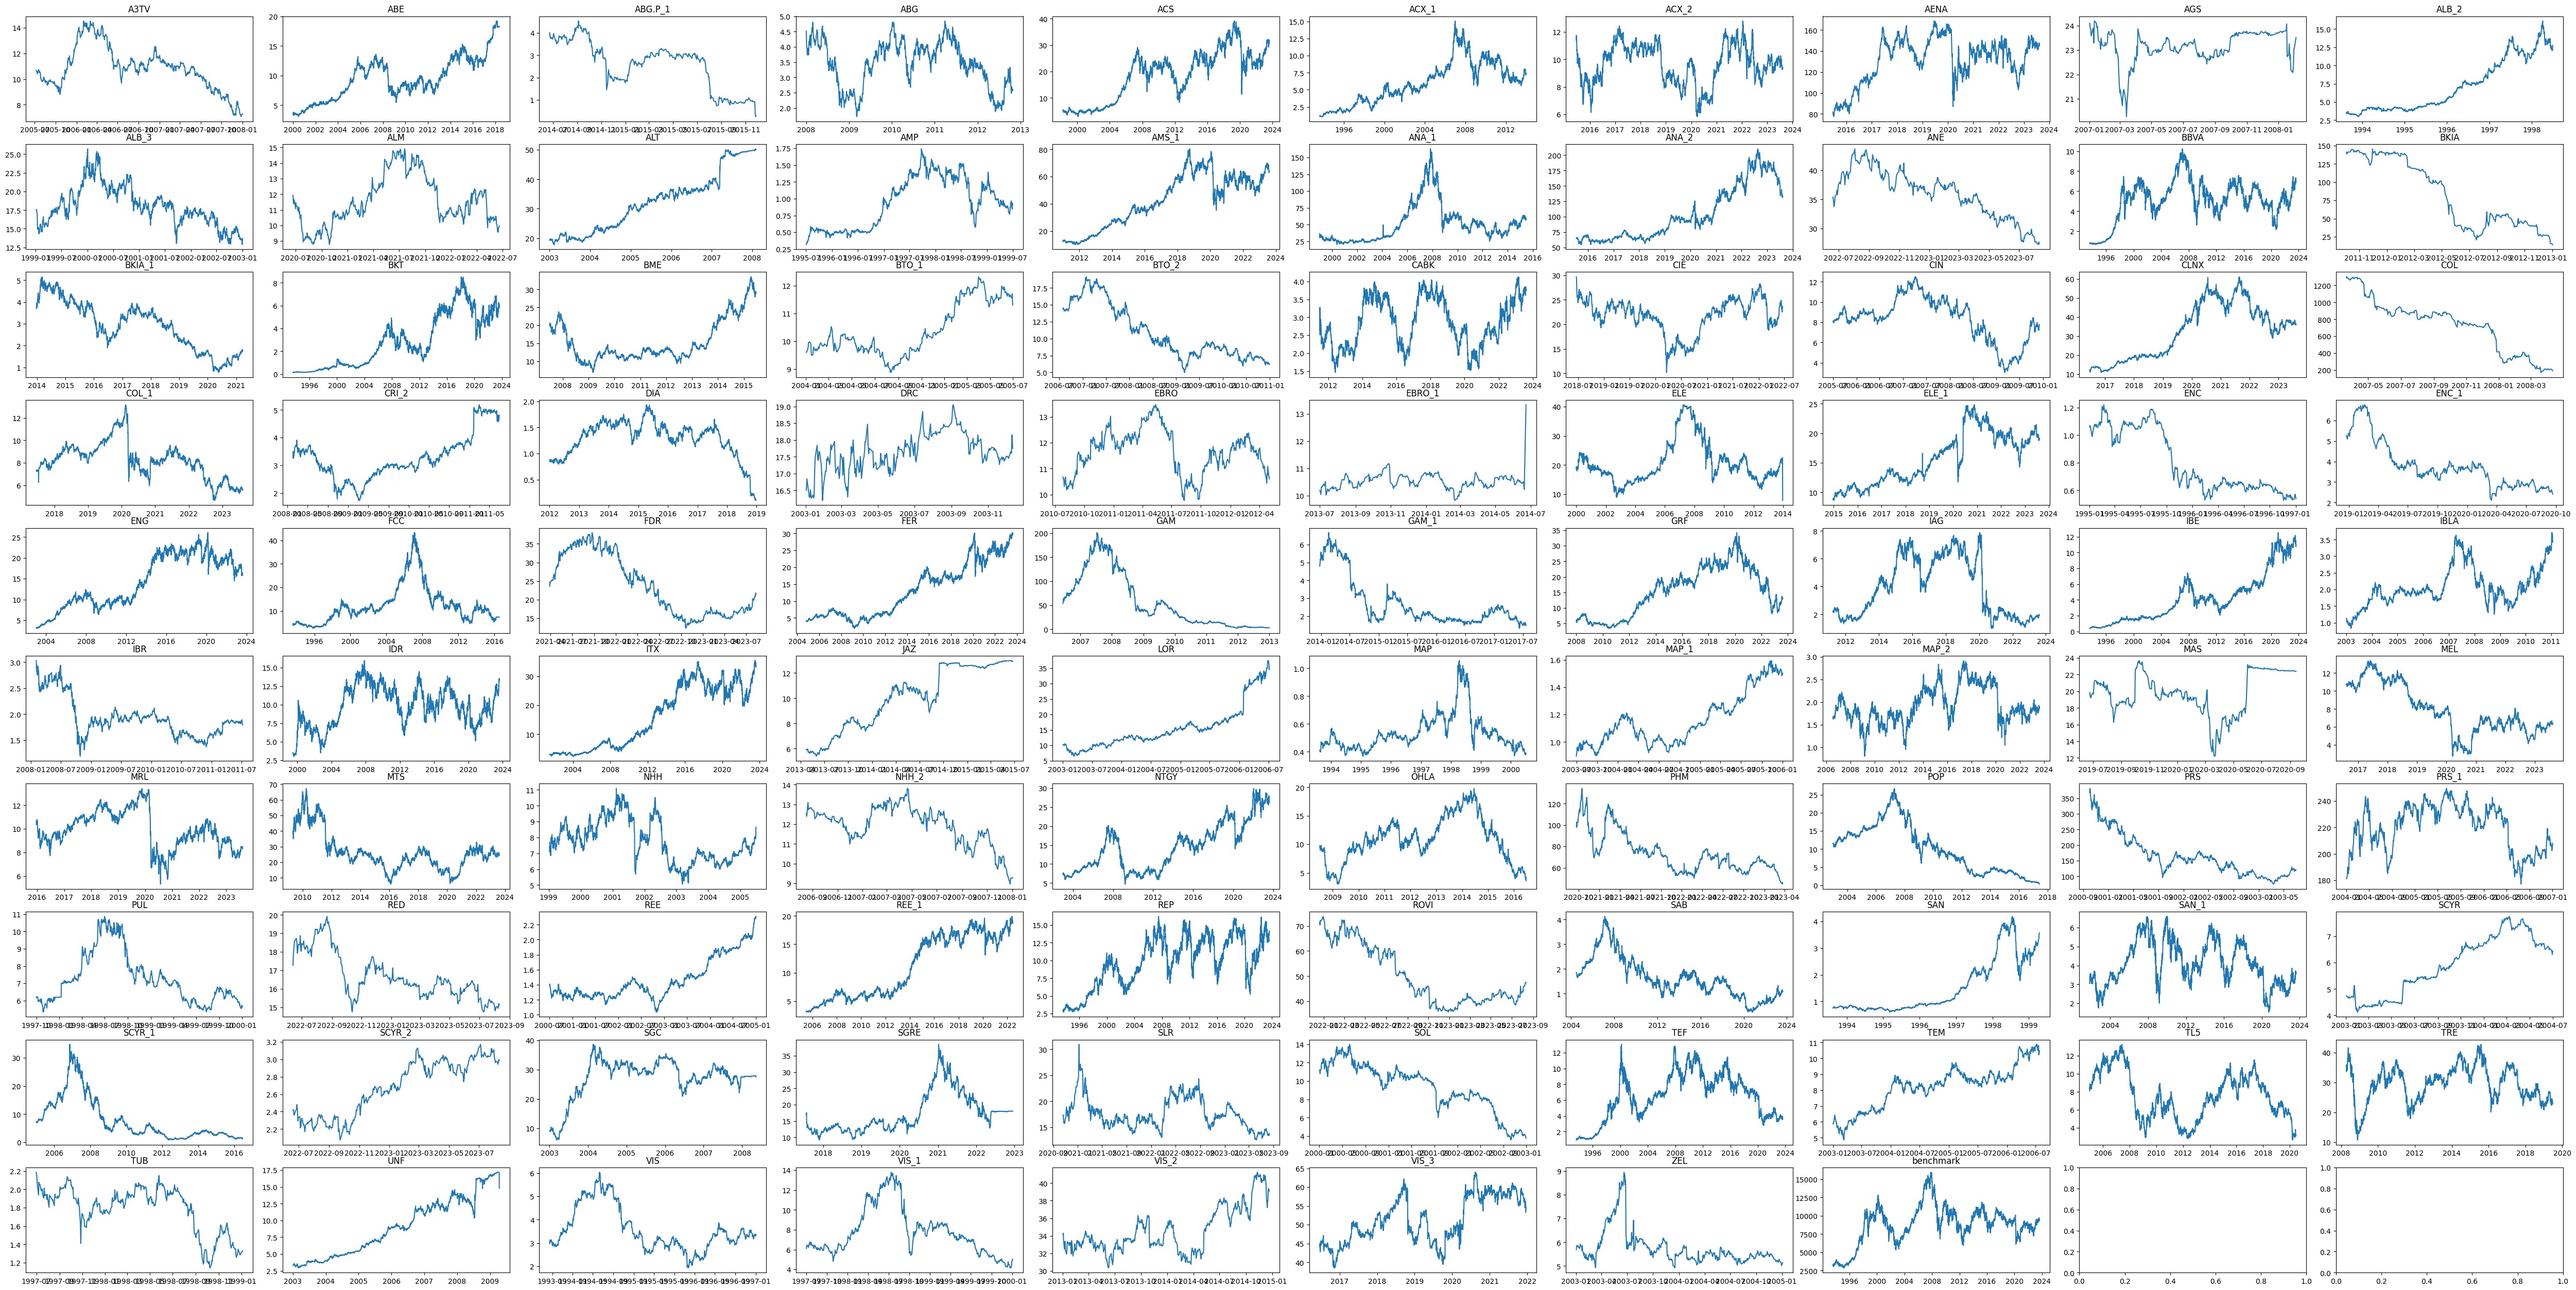

In [66]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=math.ceil(len(ibex_historical_data_cleaned.columns)/10), ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(ibex_historical_data_cleaned.columns)):

    axs[i].plot(ibex_historical_data_cleaned[ibex_historical_data_cleaned.columns[i]].dropna())
    axs[i].set_title(ibex_historical_data_cleaned.columns[i])


In [67]:
# LEEMOS EL FICHERO CON LA COMPOSICIÓN HISTORICA
ibex_constituents = pd.read_excel('data_processing/Historical Composition IBEX35.xlsx')
ibex_constituents.head()

# ibex_constituents['Exclusion'] -= BDay(1)

# ibex_constituents['Inclusion'] = ibex_constituents['Inclusion'].dt.date
# ibex_constituents['Exclusion'] = ibex_constituents['Exclusion'].dt.date

# OBTENEMOS EL DIA ACTUAL
today = datetime.date.today().strftime('%Y-%m-%d')

# COMPLETAMOS LOS DATOS NULOS EN EL FICHERO DE COMPOSICIÓN HISTORICA CON LA FECHA ACTUAL
ibex_constituents.fillna(today,inplace=True)

# DEFINIMOS UNA VARIABLE PARA TODOS LOS ACTIVOS
activos = ibex_constituents.Activo
ibex_constituents['Ticker'] = activos.apply(lambda x: x.split('_')[0])

unique_activos = list(set(activos))

In [68]:
ibex_constituents['Active Days'] = ibex_constituents['Exclusion'] - ibex_constituents['Inclusion']
ibex_constituents[['Activo','Active Days']]

Activo Active Days
0      ACE   4534 days
1      ACX    180 days
2      ALB    180 days
3      ASL   1097 days
4      BBV   3316 days
..     ...         ...
163   ROVI    603 days
164    RED    428 days
165    ANE    421 days
166    LOG    239 days
167  UNI_1    231 days

[168 rows x 2 columns]

In [69]:
ibex_constituents['Inclusion'][i],ibex_constituents['Active Days'][i],ibex_constituents['Activo'][i]

(Timestamp('2002-02-19 00:00:00'), Timedelta('1598 days 00:00:00'), 'LOR')

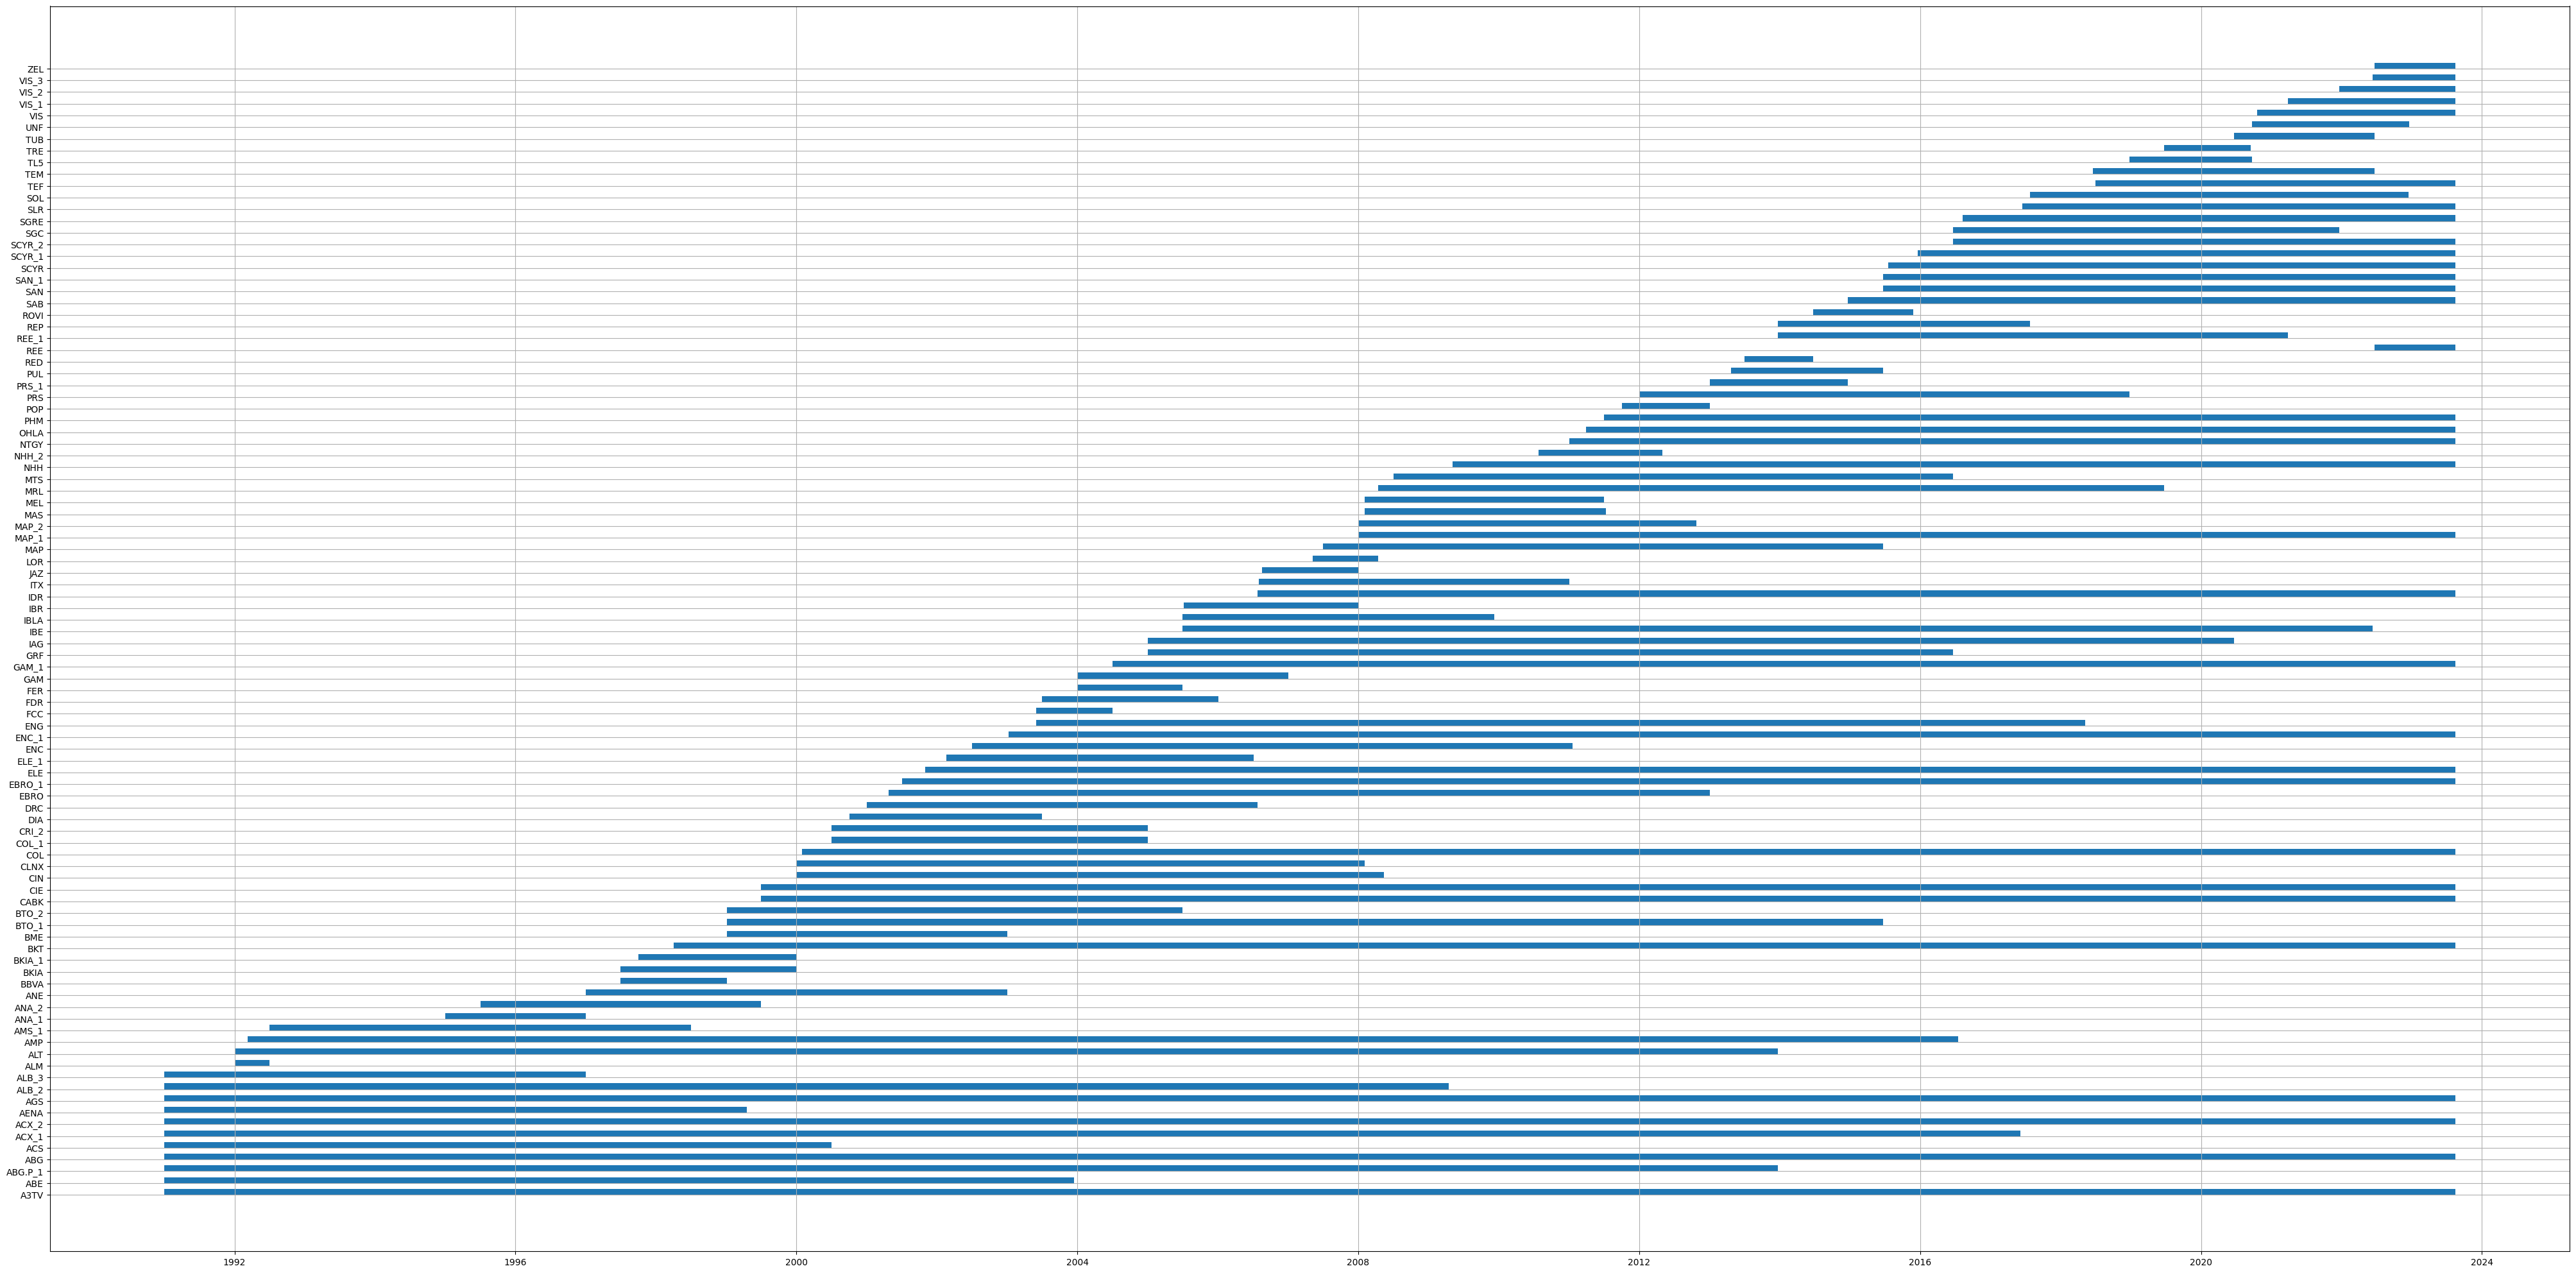

In [70]:
fig, axs = plt.subplots(figsize=(40, 20))
axs.grid(True)
fig.tight_layout()

indexes = ibex_constituents.loc[ibex_constituents['Activo'].isin(ibex_historical_data_cleaned.columns)].index
j = 0
for i in indexes:

    axs.broken_barh([(ibex_constituents['Inclusion'][i], ibex_constituents['Active Days'][i])], (j*40, 20), label=ibex_constituents.Activo[i])
    j += 1
    
axs.set_yticks(np.array(range(len(ibex_historical_data_cleaned.columns[:-1])))*40)
axs.set_yticklabels(ibex_historical_data_cleaned.columns[:-1]);

In [84]:
returns.SLR.quantile(0.99999)

0.11516481395410581

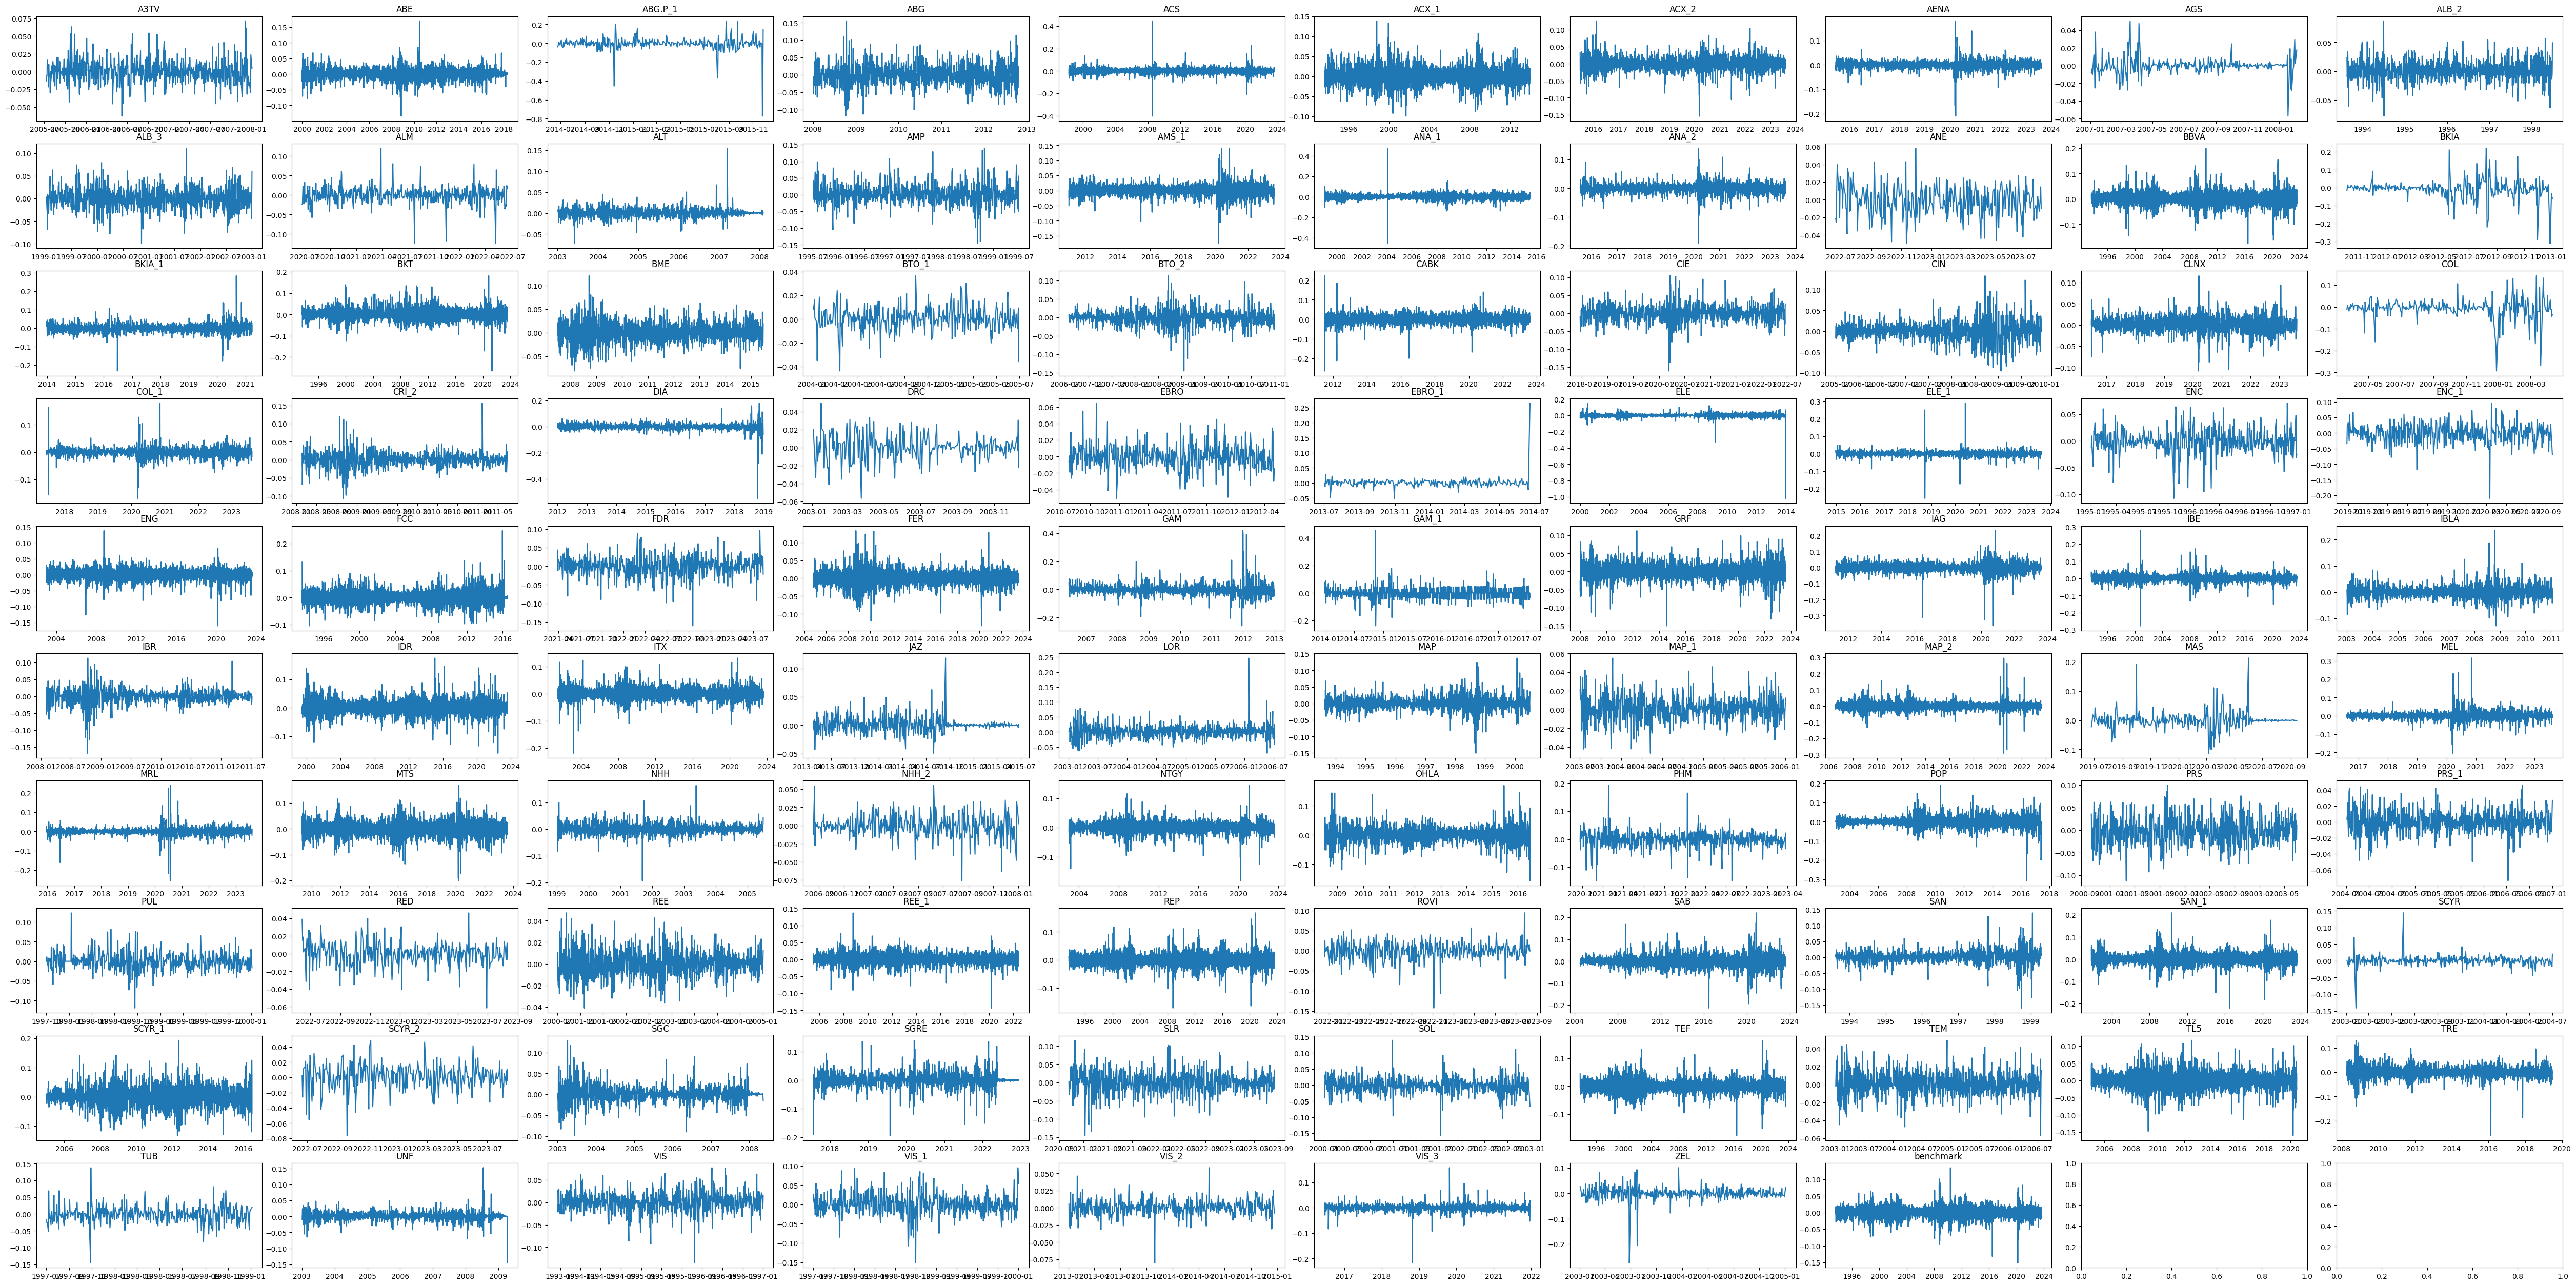

In [71]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=10,ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(returns.columns)):
    axs[i].plot(returns[returns.columns[i]].dropna())
    axs[i].set_title(returns.columns[i])

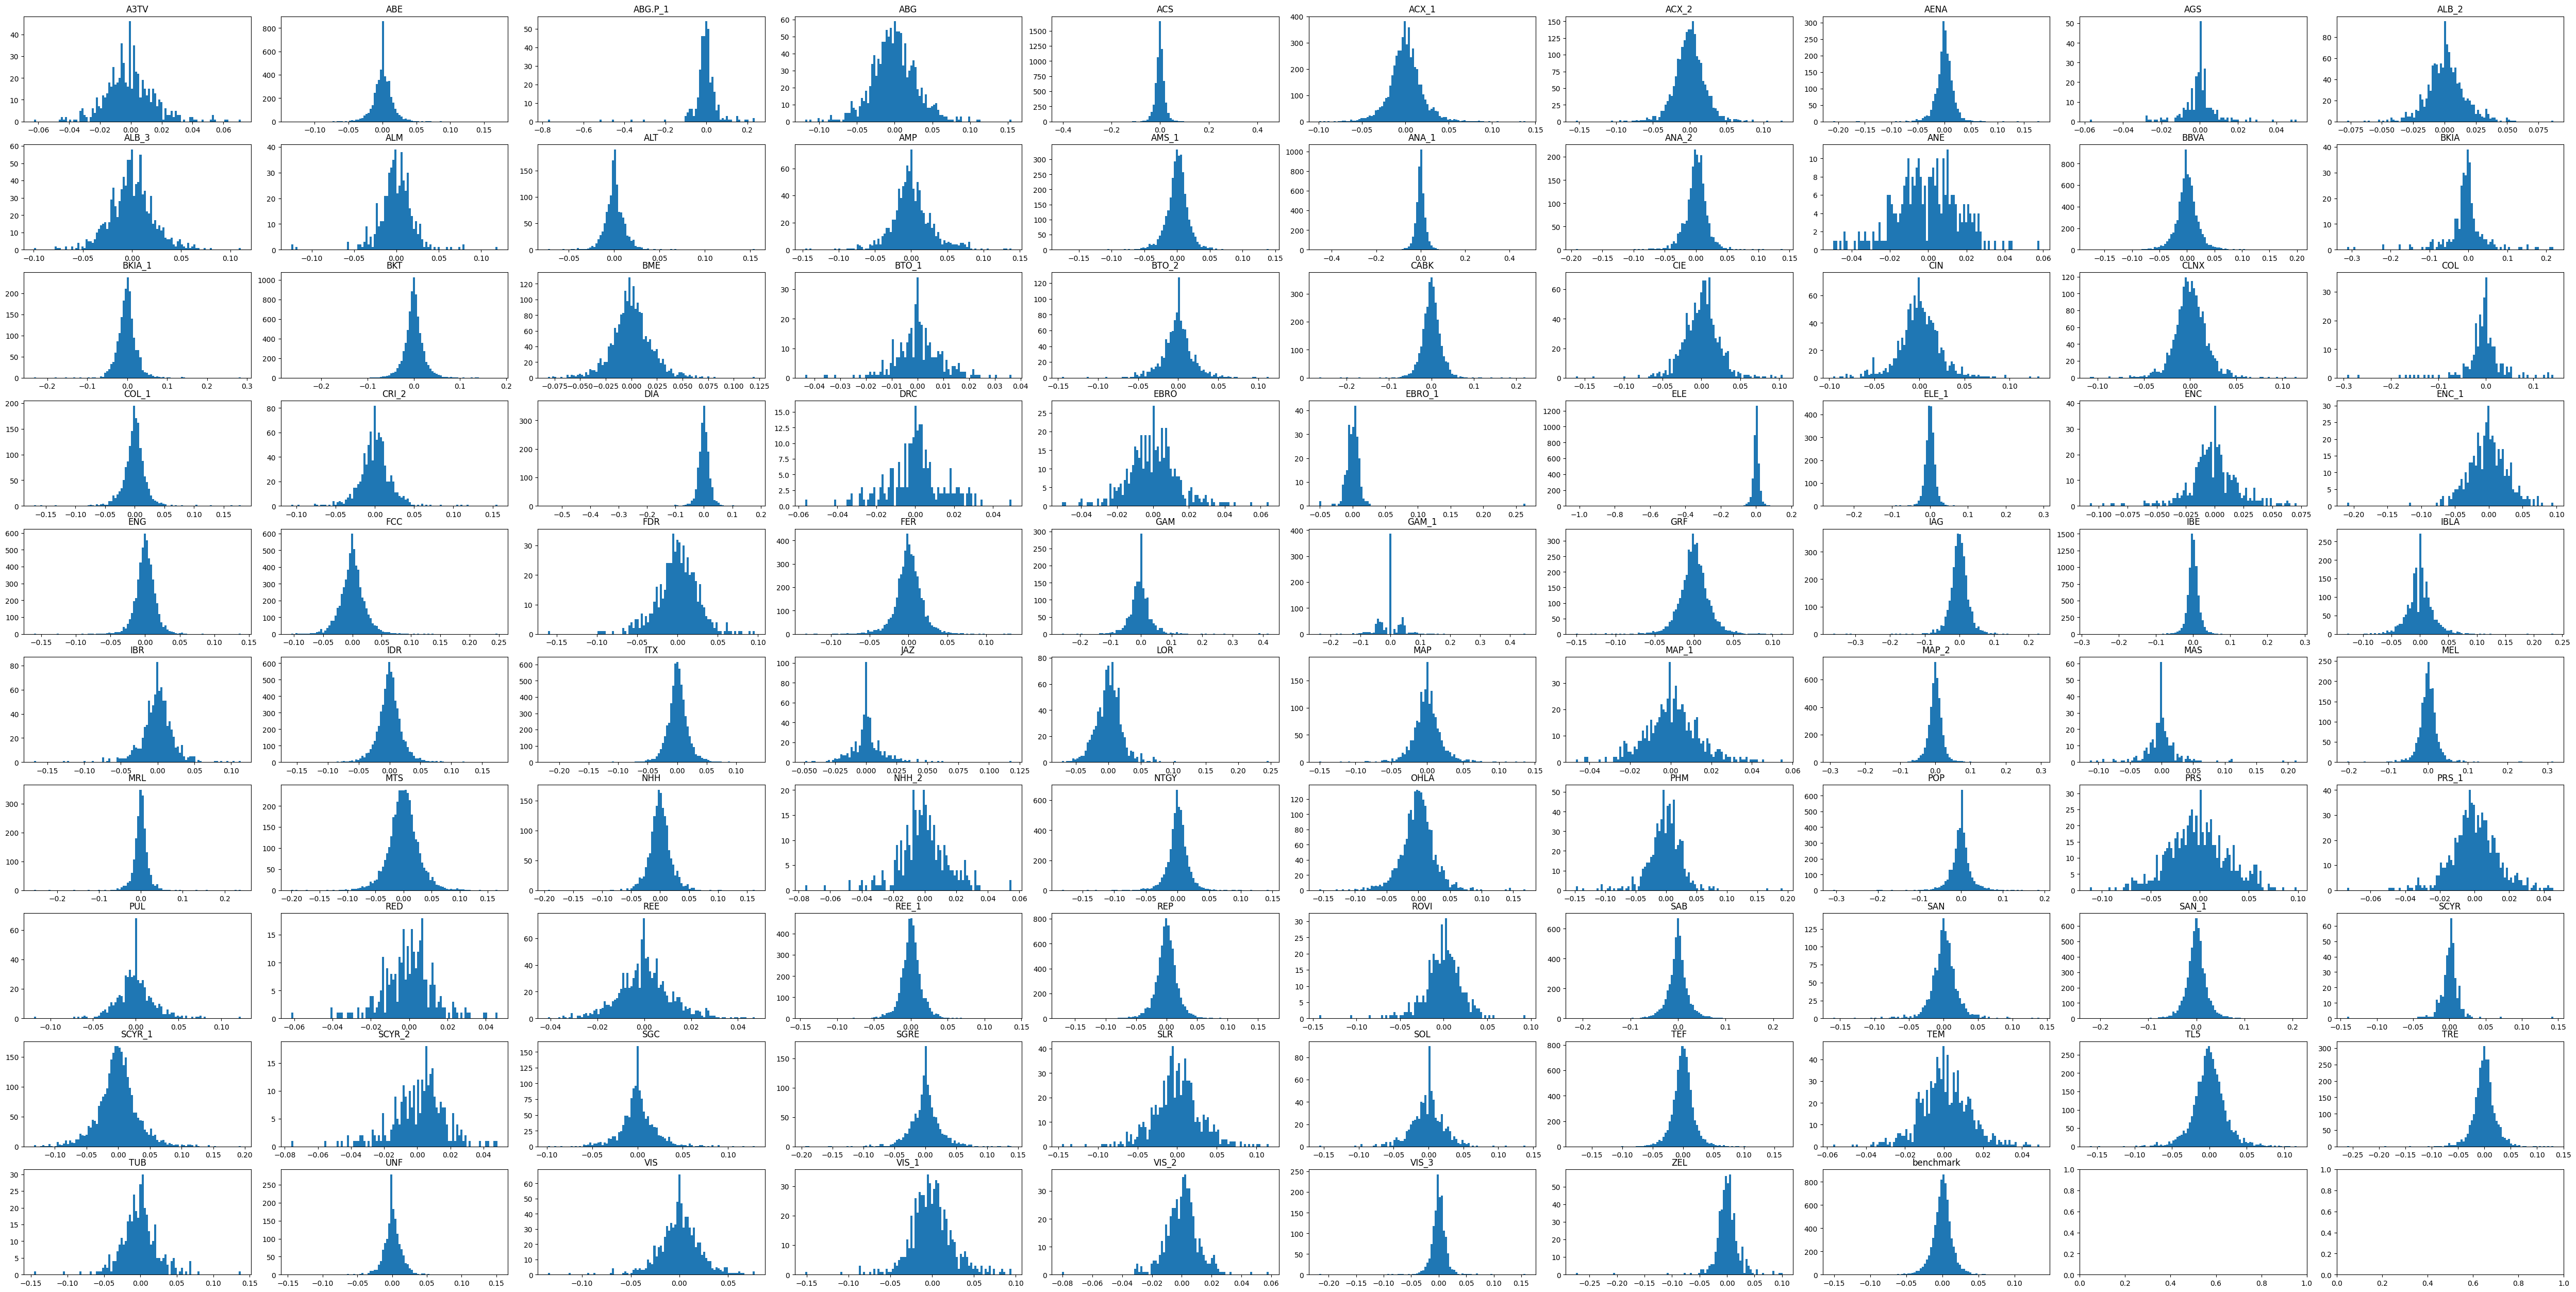

In [85]:
# GRAFICAMOS LOS RETORNOS DE TODOS LOS ACTIVOS
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(50, 25))
fig.tight_layout()
axs = axs.ravel()

for i in range(len(returns.columns)):

    axs[i].hist(returns[returns.columns[i]].dropna(),bins=100)
    axs[i].set_title(returns.columns[i])

In [921]:
returns

A3TV  ABE  ABG.P_1  ABG       ACS     ACX_1     ACX_2      AENA  \
date                                                                          
1993-08-11   NaN  NaN      NaN  NaN       NaN  0.038238       NaN       NaN   
1993-08-12   NaN  NaN      NaN  NaN       NaN  0.039881       NaN       NaN   
1993-08-13   NaN  NaN      NaN  NaN       NaN  0.017449       NaN       NaN   
1993-08-16   NaN  NaN      NaN  NaN       NaN  0.000000       NaN       NaN   
1993-08-17   NaN  NaN      NaN  NaN       NaN  0.000831       NaN       NaN   
...          ...  ...      ...  ...       ...       ...       ...       ...   
2023-08-04   NaN  NaN      NaN  NaN  0.006719       NaN  0.001933  0.011050   
2023-08-07   NaN  NaN      NaN  NaN  0.002548       NaN  0.001929 -0.004819   
2023-08-08   NaN  NaN      NaN  NaN -0.001592       NaN -0.009036  0.003445   
2023-08-09   NaN  NaN      NaN  NaN  0.007933       NaN  0.012671  0.007537   
2023-08-10   NaN  NaN      NaN  NaN       NaN       NaN       NaN       NaN   

            AGS     ALB_2  ...  TL5  TRE  TUB  UNF       VIS  VIS_1  VIS_2  \
date                       ...                                               
1993-08-11  NaN -0.001007  ...  NaN  NaN  NaN  NaN  0.005841    NaN    NaN   
1993-08-12  NaN  0.024588  ...  NaN  NaN  NaN  NaN  0.022995    NaN    NaN   
1993-08-13  NaN  0.030090  ...  NaN  NaN  NaN  NaN  0.002876    NaN    NaN   
1993-08-16  NaN -0.001881  ...  NaN  NaN  NaN  NaN  0.002733    NaN    NaN   
1993-08-17  NaN  0.023395  ...  NaN  NaN  NaN  NaN  0.025183    NaN    NaN   
...         ...       ...  ...  ...  ...  ...  ...       ...    ...    ...   
2023-08-04  NaN       NaN  ...  NaN  NaN  NaN  NaN       NaN    NaN    NaN   
2023-08-07  NaN       NaN  ...  NaN  NaN  NaN  NaN       NaN    NaN    NaN   
2023-08-08  NaN       NaN  ...  NaN  NaN  NaN  NaN       NaN    NaN    NaN   
2023-08-09  NaN       NaN  ...  NaN  NaN  NaN  NaN       NaN    NaN    NaN   
2023-08-10  NaN       NaN  ...  NaN  NaN  NaN  NaN       NaN    NaN    NaN   

            VIS_3  ZEL  benchmark  
date                               
1993-08-11    NaN  NaN   0.009776  
1993-08-12    NaN  NaN   0.017845  
1993-08-13    NaN  NaN   0.008291  
1993-08-16    NaN  NaN   0.000385  
1993-08-17    NaN  NaN   0.016909  
...           ...  ...        ...  
2023-08-04    NaN  NaN   0.006565  
2023-08-07    NaN  NaN  -0.001047  
2023-08-08    NaN  NaN  -0.006088  
2023-08-09    NaN  NaN   0.005639  
2023-08-10    NaN  NaN   0.015677  

[7603 rows x 95 columns]

In [86]:
# CALCULAMOS EL ULTIMO PRECIO MAXIMO AL QUE HA LLEGADO EL ACTIVO EN UNA SERIE HISTORICA
ibex_max_rolling = ibex_historical_data_cleaned.expanding().max()
# CALCULAMOS EL INDICE DE TIEMPO BAJO EL AGUA
underwater_ibex = (ibex_historical_data_cleaned / ibex_max_rolling)-1

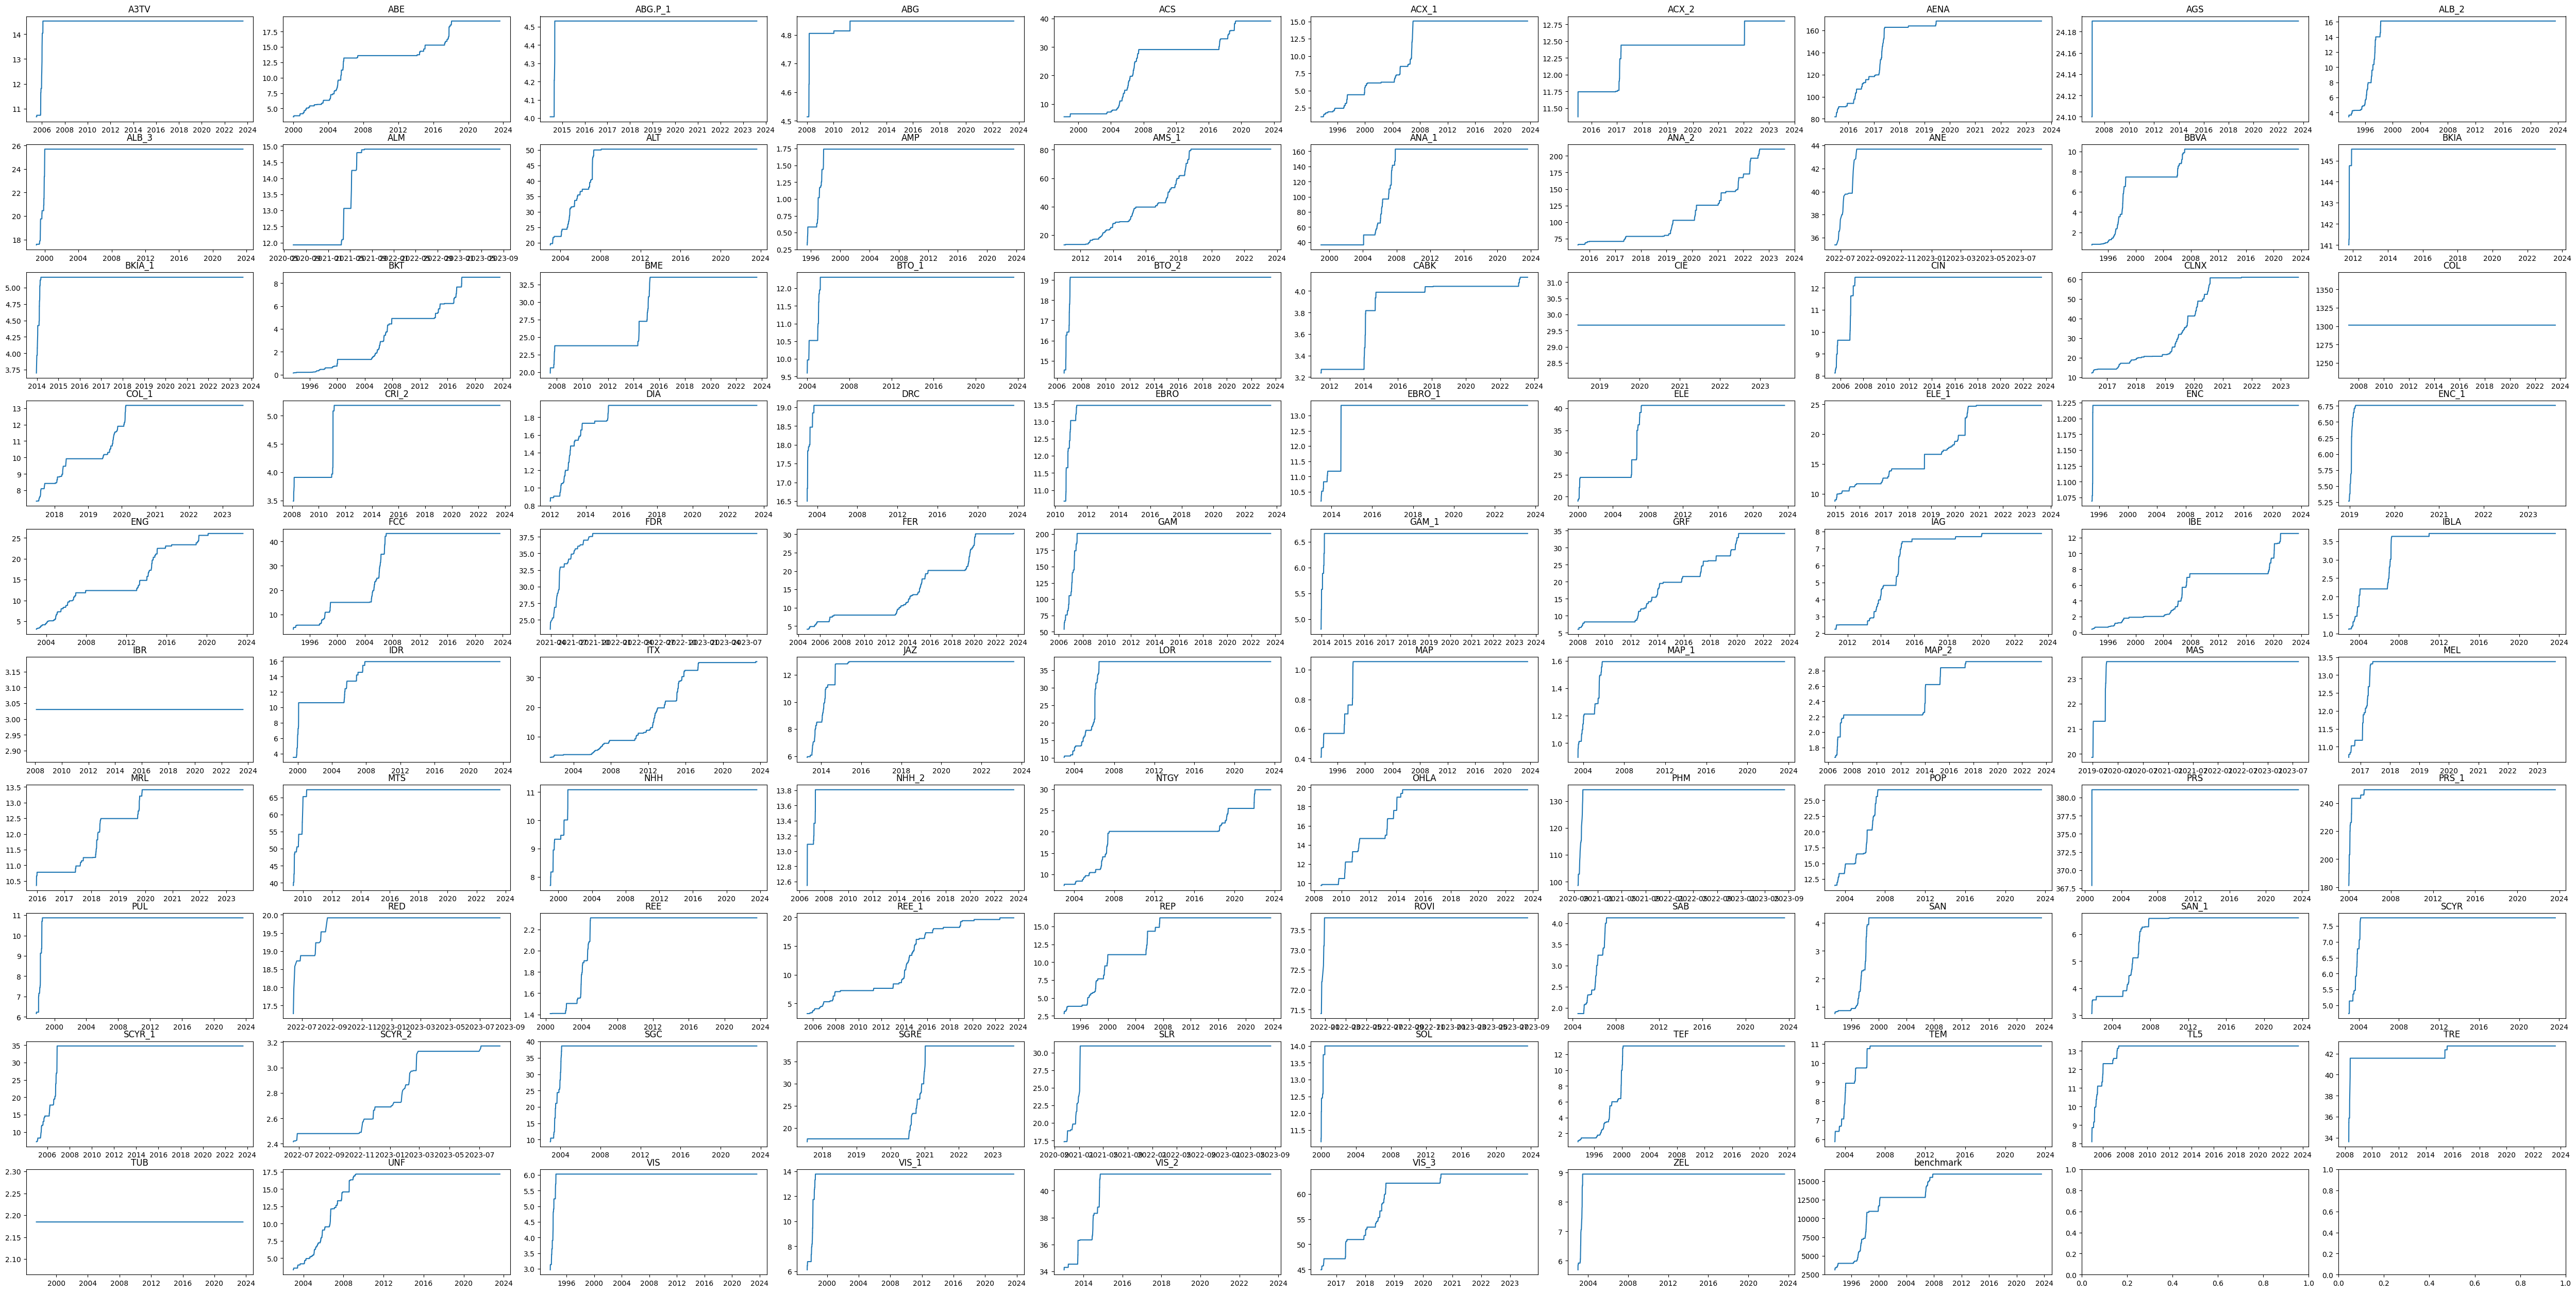

In [87]:
# GRAFICAMOS LA SERIE DE PRECIOS SOLAMENTE CON LOS MAXIMOS
fig, axs = plt.subplots(nrows=10,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(ibex_max_rolling.columns)):

    axs[i].plot(ibex_max_rolling[ibex_max_rolling.columns[i]])
    axs[i].set_title(ibex_max_rolling.columns[i])

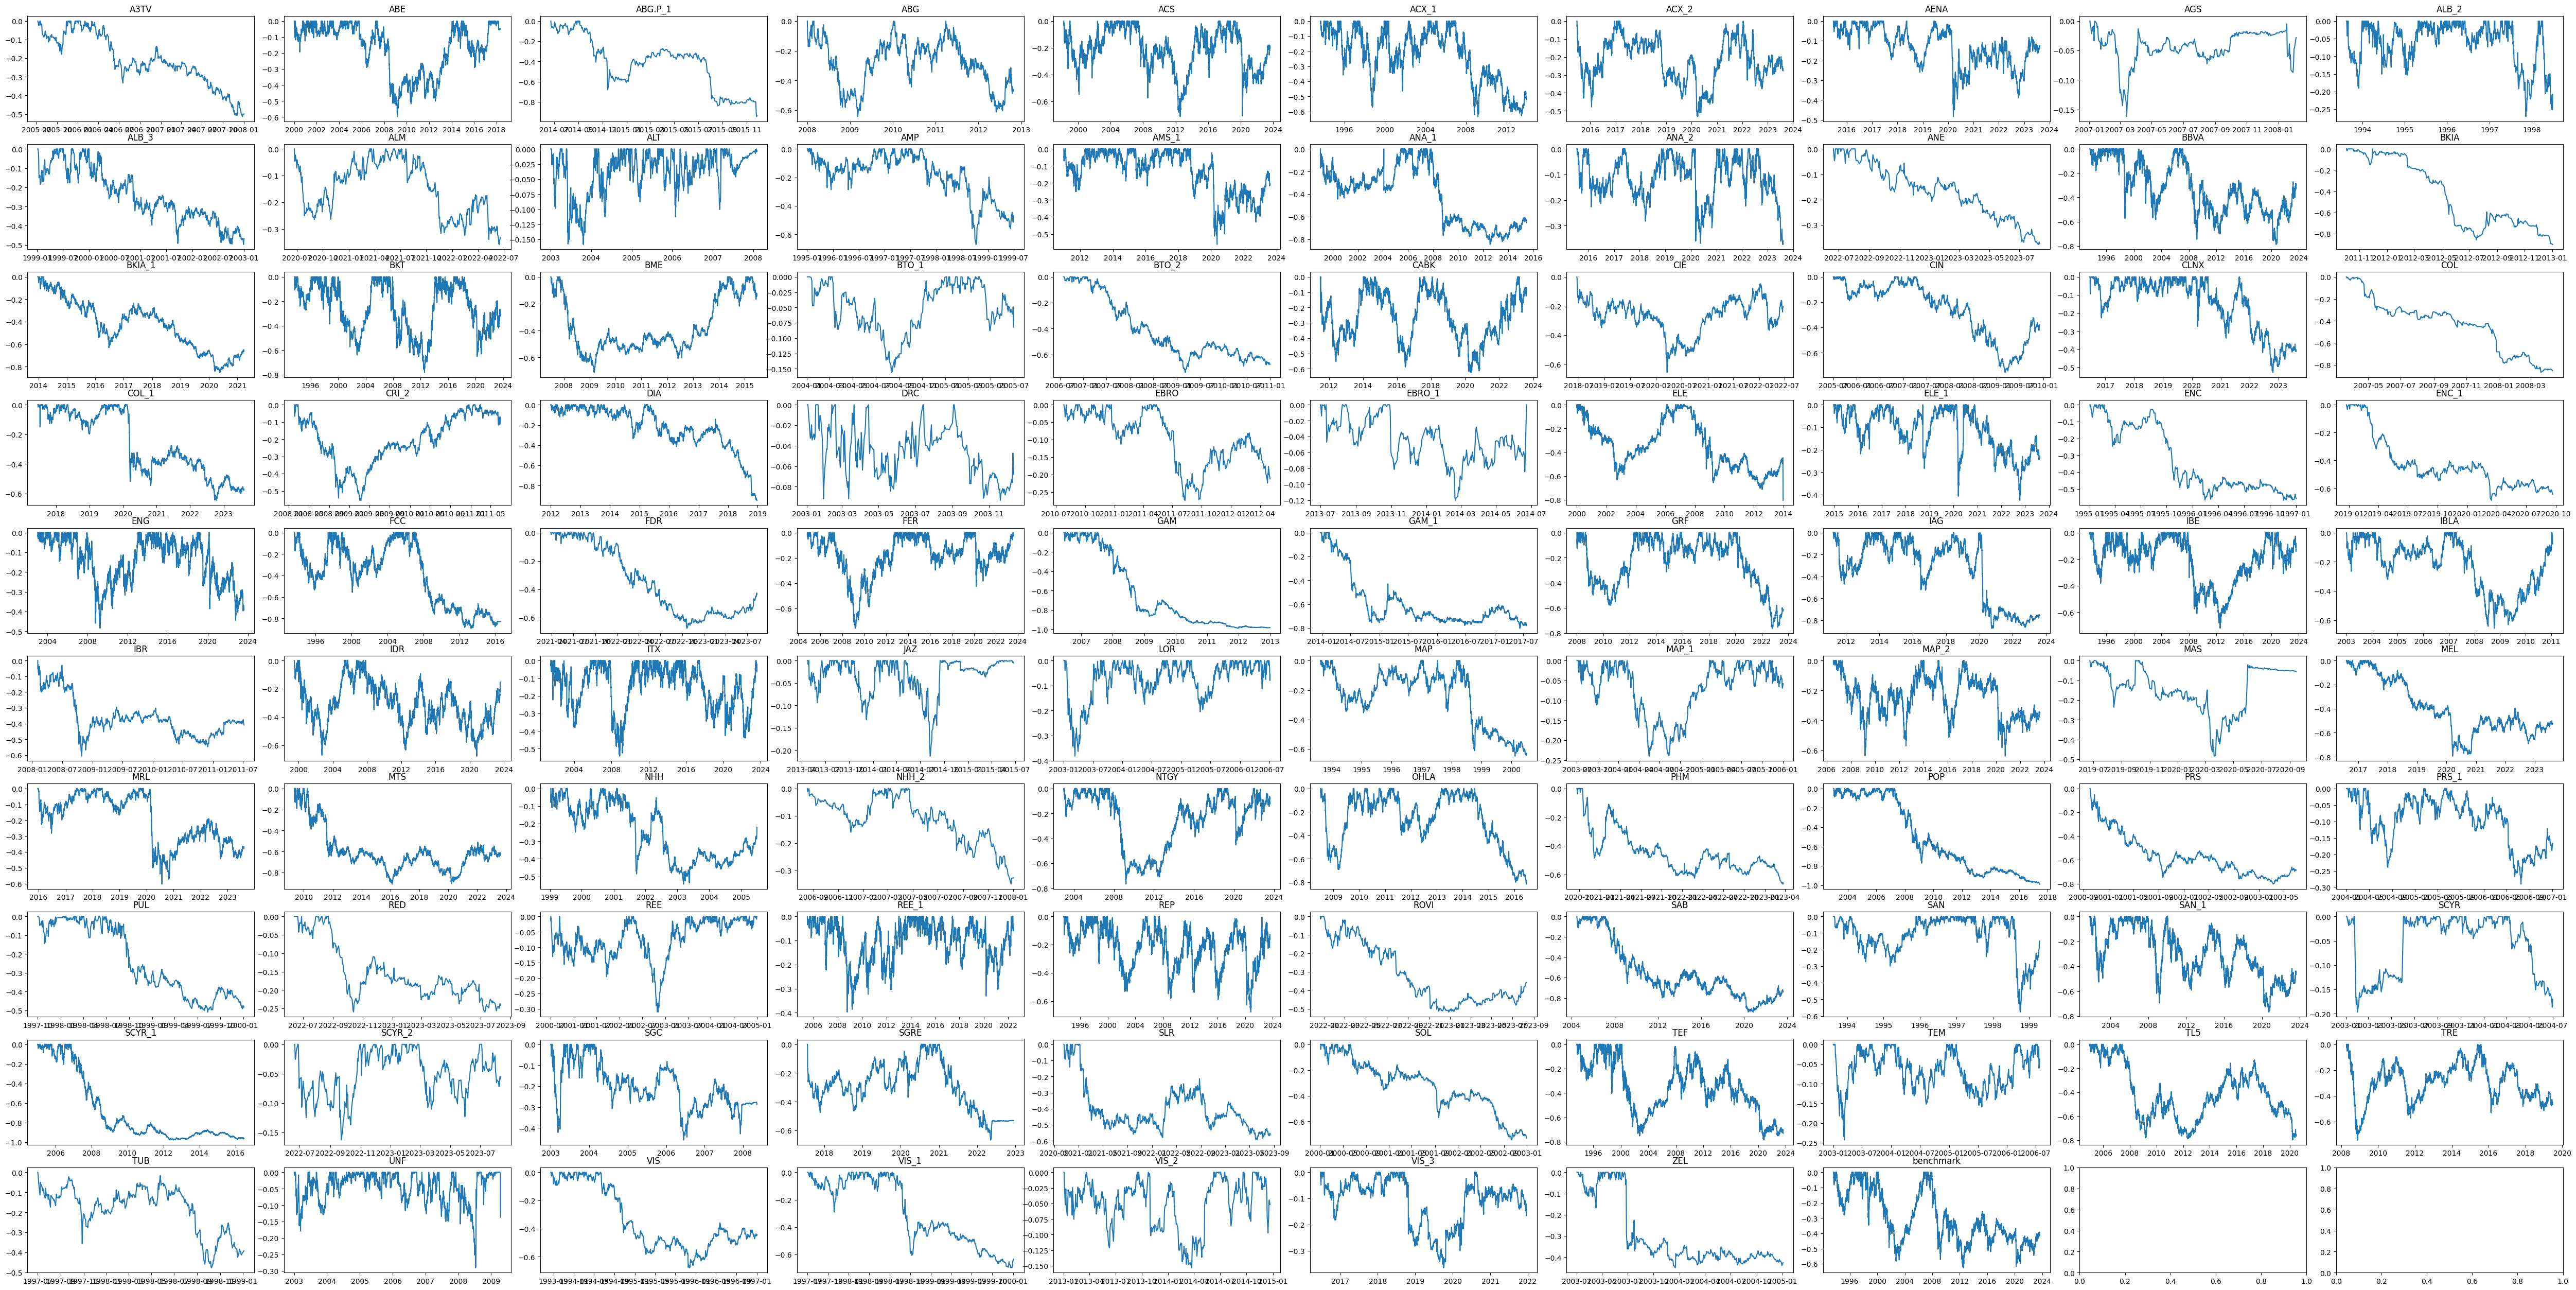

In [88]:
# GRAFICAMOS EL TIEMPO BAJO EL AGUA
fig, axs = plt.subplots(nrows=10,ncols=10, figsize=(50, 25),)
fig.tight_layout() 
axs = axs.ravel()

for i in range(len(underwater_ibex.columns)):

    axs[i].plot(underwater_ibex[underwater_ibex.columns[i]])
    axs[i].set_title(underwater_ibex.columns[i])